# Geospatial ES|QL
## FOSS4G Europe - Mostar

July 2025

## Resources

* Craig's content in [Search Labs](https://www.elastic.co/search-labs/author/craig-taverner)
* [Spatial functions documentation](https://www.elastic.co/docs/reference/query-languages/esql/functions-operators/spatial-functions)
* [Run this notebook in Google Colaboratory](https://colab.research.google.com/github/jsanz/foss4g_europe_lab/blob/main/03-geospatial_esql.ipynb)

## Setup

In [1]:
# Install required dependencies
!pip install -qU elasticsearch geopandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.3/914.3 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.4/338.4 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.8 MB/s eta 0:00:00


Start with the necessary imports, a couple tweaks, and defining a "esql" query that will make easier to see the results of a query, by generating a Pandas or Geopandas dataframe.

In [2]:
import os
import io

import warnings

from elasticsearch import Elasticsearch
from elasticsearch import ElasticsearchWarning
from elasticsearch.exceptions import BadRequestError

import pandas as pd
import geopandas as gpd
from shapely import wkb

# Hide the warning when no LIMIT is passed on a ES|QL query
warnings.filterwarnings('ignore', category=ElasticsearchWarning)

# Allow wide columns
pd.set_option('display.max_colwidth', None)

# Convert Well-known Binary to Text
def wkb_to_wkt(wkb_bytes):
    if wkb_bytes is None:
        return None
    try:
        return wkb.loads(wkb_bytes).wkt
    except Exception as e:
        print(f"Error converting WKB: {wkb_bytes} - {e}")
        return None

# Generate a Pandas Dataframe or a Geopandas Dataframe from a ES|QL query
def esql(query, geometry_col:str = "geometry", use_arrow:bool = False):
    try:
        # Query ES and create a Pandas Dataframe
        if use_arrow:
            es_response = client.esql.query(query=query.strip(), format="arrow", columnar=True)
            df = es_response.to_pandas()
        else:
            es_response = client.esql.query(query=query.strip(), format="csv")
            df = pd.read_csv(io.StringIO(str(es_response)))

        # Promote to a Geopandas Dataframe if a "geometry" column
        if geometry_col in df.columns:
            if use_arrow:
                # Arrow geometries are transferred as WKB
                df[geometry_col] = df[geometry_col].apply(wkb_to_wkt)
            gs = gpd.GeoSeries.from_wkt(df[geometry_col])
            gdf = gpd.GeoDataFrame(df, geometry=gs, crs="EPSG:4326")
            if geometry_col != "geometry":
                gdf.drop(columns="geometry")
            return gdf
        else:
            return df
    except BadRequestError as e:
        print("Something went wrong!")
        print(e.message)
        print("\r\n".join([c['reason'] for c in e.info['error']['root_cause']]))

Connect to Elasticsearch and print some cluster details

In [3]:
# Login details
ES_URL=os.getenv("ES_URL","https://foss4geurope.es.us-central1.gcp.cloud.es.io")
KB_URL=os.getenv("KB_URL","https://foss4geurope.kb.us-central1.gcp.cloud.es.io")

# API key that allows reading indices
ES_APIKEY=os.getenv("ES_APIKEY", "WkdPUjZKY0JhVEI4aFAyRmpWM186MmRvQVlLaGVwck1WbV9RSkdJT1N6UQ==")

# Load the client
client = Elasticsearch(hosts=[ES_URL], api_key=ES_APIKEY)
c_info = client.info()
is_serverless = c_info['version']['build_flavor'] == 'serverless'


# Print some cluster details
print(f"Elasticsearch URL: {ES_URL}")
print(f"Cluster name: {c_info['name']}")
print(f"Version: {c_info['version']['number'] if not is_serverless else 'serverless'}")
print("Number of documents indexed: ", client.count(index="*")['count'])

Elasticsearch URL: https://foss4geurope.es.us-central1.gcp.cloud.es.io
Cluster name: instance-0000000000
Version: 9.0.3
Number of documents indexed:  764697


## Geospatial types and conversions

Let's render some Well Known Text geometry representations from the [Wikipedia page](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry) to test the `TO_GEOSHAPE` function. There's also a `TO_GEOPOINT` function if you are only working with point geometries.

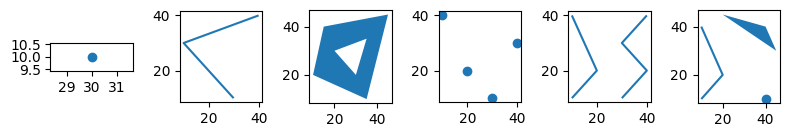

In [4]:
import matplotlib.pyplot as plt

wkt_tests = [
    "POINT (30 10)",
    "LINESTRING (30 10, 10 30, 40 40)",
    "POLYGON ((35 10, 45 45, 15 40, 10 20, 35 10),(20 30, 35 35, 30 20, 20 30))",
    "MULTIPOINT (10 40, 40 30, 20 20, 30 10)",
    "MULTILINESTRING ((10 10, 20 20, 10 40),(40 40, 30 30, 40 20, 30 10))",
    "GEOMETRYCOLLECTION (POINT (40 10), LINESTRING (10 10, 20 20, 10 40), POLYGON ((40 40, 20 45, 45 30, 40 40)))"
]

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(8, 8))

for index, wkt in enumerate(wkt_tests):
  # Define a WKT point and cast it to a geo_point
  esql(
  f"""
  ROW wkt = "{wkt}"
  | EVAL geometry=TO_GEOSHAPE(wkt)
  | KEEP geometry
  """).plot(ax=axes[index])

plt.tight_layout()
plt.show()

## Extract coordinates: `ST_X` and `ST_Y`

In [6]:
esql("""
FROM places-bosnia
| WHERE geometry IS NOT NULL
| EVAL lat = ROUND(ST_Y(geometry),5),
       lon = ROUND(ST_X(geometry),5)
| KEEP name, category, lon, lat
| LIMIT 10
""")

,name,category,lon,lat
0,The Albanian Motor Boat Club,community_services_non_profits,19.43207,42.06546
1,Restaurant Real Te Hilmia,restaurant,19.43511,42.06443
2,Zum Rappen,restaurant,19.43651,42.06392
3,Labiatan Zogaj,restaurant,19.44496,42.06119
4,Sunset Restaurant,restaurant,19.44501,42.06131
5,Drini Times,sports_club_and_league,19.44980,42.06035
6,Restaurant Lembus,restaurant,19.45307,42.05968
7,Piccolino,diner,19.45442,42.05942
8,Lago di Scutari,lake,19.45449,42.05950
9,Bar Restorant Vllaznia,bar,19.45457,42.05945


## Distance computations

 Let's find the [GeoChicas take Mostar](https://2025.europe.foss4g.org/schedule/geochicas-take-mostar/) venue by searching in our `places-bosnia` index and save the first result.

In [11]:
charlie = esql("""
FROM places-bosnia
| WHERE name like "Charlie Bar and Snack"
| LIMIT 1
""")

if len(charlie.index) == 0:
  print("No results found!")
else:
  charlie_feature = charlie.iloc[0]
  print(charlie_feature['name'])
  print(f"Categories: {charlie_feature['category']} - {charlie_feature['alt_categories']}")
  print(f"Contact: ☎ {charlie_feature['phones']}, {charlie_feature['websites']}")
  print(charlie_feature['geometry'])

Charlie Bar and Snack
Categories: bar - [fast_food_restaurant, professional_services]
Contact: ☎ 38763100400, https://charlie.ba/
POINT (17.7950102 43.3440312)



    FROM places-bosnia
    | EVAL dist_charlie = ST_DISTANCE(TO_GEOPOINT("POINT (17.7950102 43.3440312)"), geometry)
    | WHERE dist_charlie < 1000
    | KEEP name, category, dist_charlie, geometry
    | LIMIT 50000
    


<Axes: >

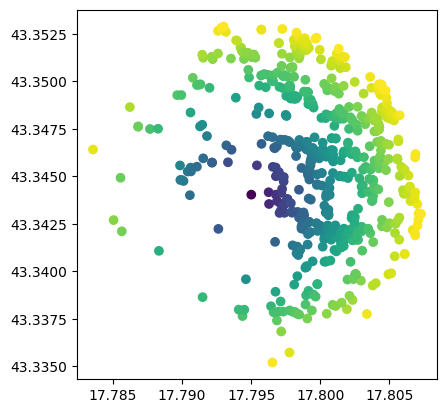

In [12]:
# Save the distance in a field, then use it to
# filter all geometries and thematic mapping
query = f"""
    FROM places-bosnia
    | EVAL dist_charlie = ST_DISTANCE(TO_GEOPOINT("{charlie_feature["geometry"]}"), geometry)
    | WHERE dist_charlie < 1000
    | KEEP name, category, dist_charlie, geometry
    | LIMIT 50000
    """
print(query)
esql(query).plot(column="dist_charlie")

We'll use that query later in Kibana.

## Geometry aggregation: `ST_EXTENT_AGG` , and `ST_CENTROID_AGG` and geometry functions `ST_ENVELOPE`, `ST_XMAX`, `ST_YMAX`, etc.

In [13]:
# Get the envelope of a geometry, this function only works on single rows
# We use the use_arrow=False param in our helper function to return the
# envelope as a WKT instead of a binary.
query = f"""
    FROM ne_countries
    | WHERE iso_a2 LIKE "BA"
    | EVAL geometry_envelope = ST_ENVELOPE(geometry)
    | KEEP name, geometry_envelope
    | LIMIT 1
    """
esql(query, use_arrow=False)

,name,geometry_envelope
0,Bosnia and Herz.,"BBOX (15.716073852000108, 19.618884725000044, 45.28452382500008, 42.55921213800009)"


In [14]:
# To play with the centroid aggregation and the other geometry functions let's
# try the following:
# 1- Comput the distance
# 2- Filter those 1km away from Charlie's
# 3- Grouping places by category, get the count, envelope, and centroid
# 4- Filter only categories with more than 10 results
# 5- Get the boundaries of the envelopes
# 6- For each row, print the category, count, boundaries, and
#    centroid geometry, sorting by counts

query = f"""
    FROM places-bosnia
    // First compute the distance to Charlie Bar and Snack
    | EVAL dist_charlie = ST_DISTANCE(TO_GEOPOINT("{charlie_feature["geometry"]}"), geometry)

    // Filter those within a kilometer
    | WHERE dist_charlie < 1000

    // Compute the count, and grouping by category,
    // aggrate the envelope and centroid geometries
    | STATS count = COUNT(),
            geometry_envelope = ST_EXTENT_AGG(geometry),
              centroid = ST_CENTROID_AGG(geometry)
              BY category

    // Filter those categories wtih less than 10 venues
    | WHERE count > 10

    // Compute the envelope bounds
    | EVAL lat_max = ST_YMAX(geometry_envelope),
             lon_max = ST_XMAX(geometry_envelope),
             lat_min = ST_YMIN(geometry_envelope),
             lon_min = ST_XMIN(geometry_envelope)
    | KEEP count, category, lat_max, lon_max, lat_min, lon_min, centroid
    | SORT count DESC
    """
print(query)
esql(query, use_arrow=False)


    FROM places-bosnia
    // First compute the distance to Charlie Bar and Snack
    | EVAL dist_charlie = ST_DISTANCE(TO_GEOPOINT("POINT (17.7950102 43.3440312)"), geometry)

    // Filter those within a kilometer
    | WHERE dist_charlie < 1000

    // Compute the count, and grouping by category,
    // aggrate the envelope and centroid geometries
    | STATS count = COUNT(),
            geometry_envelope = ST_EXTENT_AGG(geometry),
              centroid = ST_CENTROID_AGG(geometry)
              BY category

    // Filter those categories wtih less than 10 venues
    | WHERE count > 10

    // Compute the envelope bounds
    | EVAL lat_max = ST_YMAX(geometry_envelope),
             lon_max = ST_XMAX(geometry_envelope),
             lat_min = ST_YMIN(geometry_envelope),
             lon_min = ST_XMIN(geometry_envelope)
    | KEEP count, category, lat_max, lon_max, lat_min, lon_min, centroid
    | SORT count DESC
    


,count,category,lat_max,lon_max,lat_min,lon_min,centroid
0,43,beauty_salon,43.352649,17.804928,43.335197,17.788327,POINT (17.799854400719322 43.34607028456535)
1,41,cafe,43.351507,17.805411,43.337764,17.787678,POINT (17.79920478601281 43.34575539647897)
2,20,college_university,43.352563,17.807274,43.341363,17.789852,POINT (17.797850808128715 43.34477888094261)
3,19,bar,43.351300,17.804279,43.341869,17.786222,POINT (17.79920242971888 43.34628158567571)
4,18,professional_services,43.352752,17.806833,43.338247,17.791080,POINT (17.80015525408089 43.34577495697886)
5,15,restaurant,43.351444,17.804731,43.337513,17.797221,POINT (17.8010140825063 43.34602358657867)
6,14,hospital,43.350711,17.805390,43.337865,17.789876,POINT (17.797520836549147 43.34567683782162)
7,14,community_services_non_profits,43.349486,17.804020,43.337938,17.792170,POINT (17.799646906288608 43.34396989018257)
8,12,shopping,43.351172,17.803711,43.341148,17.783554,POINT (17.798194403294474 43.34646971896291)
9,11,pizza_restaurant,43.352293,17.806487,43.339894,17.798225,POINT (17.801724999973718 43.34623912772672)


## Geometry comparisons: `ST_INTERSECTS`, `ST_WITHIN`, etc

To filter by spatial relationships, OGC describes a set of `ST_` functions that check if two geometries intersect, are completely covered, or disjoint, etc. ES|QL supports `ST_INTERSECTS`, `ST_DISJOINT`, `ST_CONTAINS`, and `ST_WITHIN`

In [23]:
# Let's do an antipattern of finding geometries
# by intersecting them against a buffer
BUFFER_DISTANCE = 0.01
SIMPLIFY_TOLERANCE = 0.0005

charlie_buffer = charlie.copy()
charlie_buffer["geometry"] = charlie_buffer["geometry"].buffer(BUFFER_DISTANCE).simplify(SIMPLIFY_TOLERANCE)
charlie_wkt = charlie_buffer["geometry"].iloc[0].wkt

/tmp/ipython-input-23-4114814959.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  charlie_buffer["geometry"] = charlie_buffer["geometry"].buffer(BUFFER_DISTANCE).simplify(SIMPLIFY_TOLERANCE)


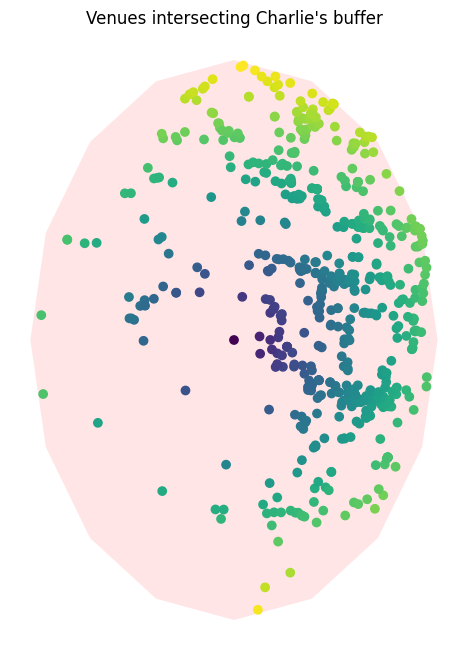

In [24]:
# Intersect bosnia places with our buffer computing the distance to Charlie's
query = f"""
    FROM places-bosnia
    | WHERE ST_INTERSECTS(
        TO_GEOSHAPE("{charlie_wkt}"),
        geometry
    )
    | EVAL dist_charlie = ST_DISTANCE(TO_GEOPOINT("{charlie_feature["geometry"]}"), geometry)
    | KEEP name, category, geometry, dist_charlie
    | LIMIT 50000
    """
venues = esql(query)

# Render the buffer and venues in a single plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

charlie_buffer.plot(ax=ax, color="red", alpha=0.1)
venues.plot(ax=ax, column="dist_charlie")
ax.set_title("Venues intersecting Charlie's buffer")
ax.set_axis_off()
plt.show()

## Using ES|QL for choropleth mapping

Let's use ES|QL to query a dataset of [OpenSky positions](https://opensky-network.org/) where each record has been reverse geocoded against the `ne_countries` dataset to assign a `country.iso_a2` field. The query will aggregate first by country and the run a `LOOKUP JOIN` to get the country geometries for local rendering.

In [26]:
# Let's first check a single position record
esql("""
FROM flight_tracking_*
| WHERE country.iso_a2 IS NOT NULL
| LIMIT 1
""").iloc[0]

,0
@timestamp,2025-07-10T12:11:01.703Z
baroAltitude,10363.200195
callsign,TVF6307
callsign.keyword,TVF6307
country.iso_a2,FR
geoAltitude,10828.019531
heading,328.649994
icao24,39de4e
lastContact,2025-07-10T12:10:42.000Z
location,POINT (4.6112 46.6664)


In [27]:
# Check how many flights have been reverse geocoded

all_records = esql("""
FROM flight_tracking_*
| STATS count = COUNT()
| KEEP count
""")['count'].iloc[0]

with_country = esql("""
FROM flight_tracking_*
| WHERE country.iso_a2 IS NOT NULL
| STATS count = COUNT()
| KEEP count
""")['count'].iloc[0]

print(f"Total records: {all_records}")
print(f"Records with country: {with_country}")

# NOTE:
# We can do the same computations directly with the Python client
# client.count(index="flight_tracking_*")['count']
# Add a filter to the count query to check if a field exists
# client.count(index="flight_tracking_*", body={"query": {"exists": {"field": "country.iso_a2"}}})['count']


Total records: 512215
Records with country: 94832


In [48]:
# Retrieve all countries for our simple basemap
all_countries = esql("FROM  ne_countries | KEEP iso_a2, name, geometry")

# Return the countries that intersect with the positions dataset
flights_per_country = esql(
"""
// Get flight positions
FROM flight_tracking_*
// Filter those that were reverse geocoded into a country
| WHERE country.iso_a2 IS NOT NULL

// Rename the join field to have the same name as the lookup table
| RENAME country.iso_a2 AS iso_a2

// Aggregate the flight positions by country
| STATS count = COUNT(), flights = COUNT_DISTINCT(callsign.keyword) BY iso_a2

// Join with the lookup table
| LOOKUP JOIN ne_countries ON iso_a2

// Remove dependencies with same iso_a2 than their main countries
| WHERE type NOT LIKE "Dependency"

| SORT count DESC
| KEEP iso_a2, count, flights, geometry
"""
)

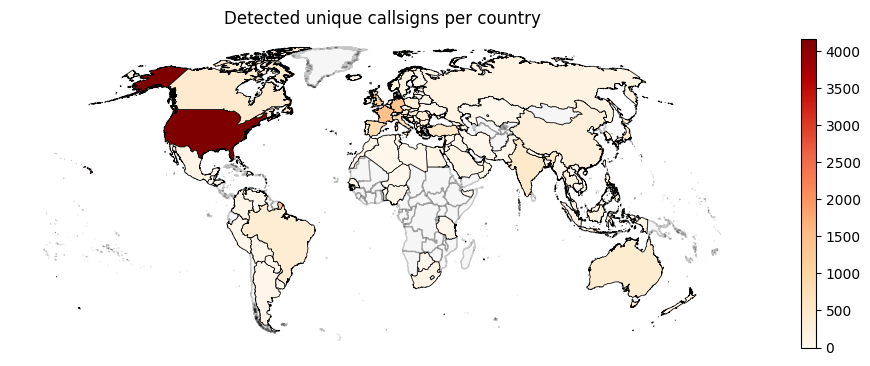

In [49]:
# Project the dataframes to the Robinson projection
all_countries_proj = all_countries.to_crs("ESRI:54030")
flights_per_country_proj = flights_per_country.to_crs("ESRI:54030")

# Render the flight positions per country
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
all_countries_proj.plot(ax=ax, alpha=0.2, color="lightgrey", edgecolor="black")
flights_per_country_proj.plot(
    ax=ax, column="flights", cmap="OrRd", legend=True, markersize=10,
    edgecolor="black", linewidth=0.5, legend_kwds={'shrink': 0.4}
)
ax.set_title("Detected unique callsigns per country")
ax.set_axis_off()
plt.show()